In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import sys
import os
import math
sys.path.append('../..')
import scipy.optimize as opt

from models.optim.opt_gaboh_single_int import SEIR

In [3]:
def calculate_opt(intervention):
    R0 = 2.2 
    T_inf = 2.9
    T_trans = T_inf/R0
    T_inc = 5.2
    T_recov_mild = (14 - T_inf)
    T_hosp = 5
    T_recov_severe = (31.5 - T_inf)
    T_death = 32

    P_severe = 0.2
    P_fatal = 0.02
    P_mild = 1 - P_severe - P_fatal

    N = 7e6
    I0 = 1.0

    # new_R0 = 0.74
    # intervention_amount = R0/new_R0
    intervention_day = intervention[0]
    intervention_duration = intervention[1]
    intervention_amount = intervention[2]
 
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, intervention_day, intervention_amount, intervention_duration]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=400)
    states_int_array = (sol.y*N).astype('int')
    
    E = states_int_array[1]
    I = states_int_array[2]
    H = states_int_array[5]
    F = states_int_array[8]
    
    objective = N*intervention_duration*0.8 + 1e5 + F[-1]*1e4 + np.sum(H)

    return(objective/1e8)

In [25]:
res = opt.minimize(calculate_opt, [50,100,3], method='nelder-mead',options={'xatol': 1e0, 'disp': True, 'fatol': 1e-2, 'maxiter': 1e4, 'maxfev': 1e4})

Optimization terminated successfully.
         Current function value: 0.744089
         Iterations: 61
         Function evaluations: 136


In [27]:
res = opt.minimize(calculate_opt, [50,100,3], method='Powell',options={'xtol': 1e0, 'disp': True, 'ftol': 1e-2, 'maxiter': 1e4, 'maxfev': 1e4})

Optimization terminated successfully.
         Current function value: 2.542109
         Iterations: 3
         Function evaluations: 124


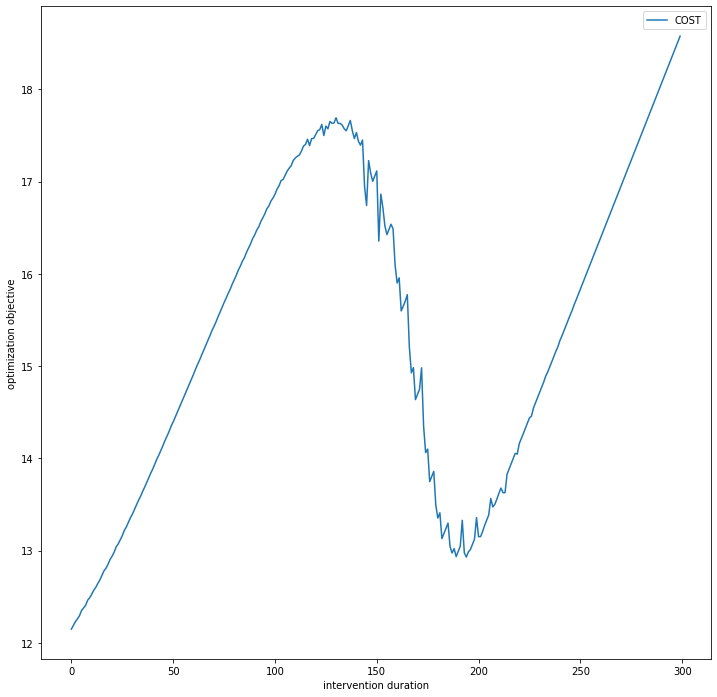

In [4]:
obj = np.zeros(300)
for i in range(300):
    obj[i] = calculate_opt([100, i, 3])
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(12, 12))
plt.plot(ind, obj, label='COST')
plt.ylabel('optimization objective')
plt.xlabel('intervention duration')
plt.legend()
plt.show()

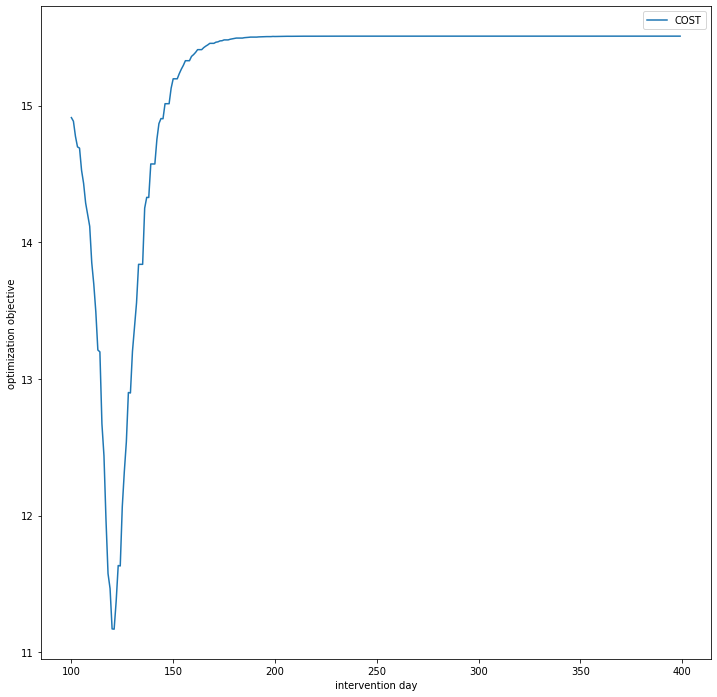

In [5]:
obj = np.zeros(300)
for i in range(100,400):
    obj[i-100] = calculate_opt([i, 60, 3])
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(12, 12))
plt.plot(ind+100, obj, label='COST')
plt.ylabel('optimization objective')
plt.xlabel('intervention day')
plt.legend()
plt.show()